Starting:ieegFeatures:2016-09-23 07:02:24.696676
Cols:502
502
Running:XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0.017, learning_rate=0.15, max_delta_step=0, max_depth=12,
       min_child_weight=3, missing=None, n_estimators=2000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.9)shape:(5971, 256)
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0.017, learning_rate=0.15, max_delta_step=0, max_depth=12,
       min_child_weight=3, missing=None, n_estimators=2000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.9)
ROC AUC:0.840255129906
LOG LOSS:0.269486532938


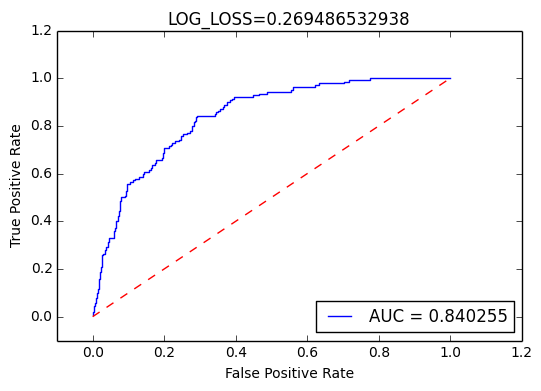

result ~ skew_16 + kurt_1 + psd_152 + psd_103 + kurt_5 + skew_9 + kurt_6 + median_2 + kurt_10 + skew_13 + median_11 + skew_10 + kurt_13 + median_9 + psd_139 + skew_7 + psd_132 + skew_1 + skew_15 + psd_131 + psd_145 + skew_3 + skew_11 + mean_7 + psd_136 + psd_45 + psd_67 + psd_97 + median_12 + psd_81 + psd_146 + psd_151 + psd_149 + psd_36 + median_3 + kurt_9 + psd_157 + psd_98 + psd_63 + psd_148 + psd_89 + std_3 + psd_155 + skew_4 + median_10 + psd_86 + psd_87 + psd_120 + psd_51 + kurt_16 + median_7 + psd_94 + median_4 + psd_116 + psd_7 + median_8 + skew_6 + skew_5 + mean_12 + median_16 + var_4 + skew_14 + psd_8 + psd_130 + kurt_7 + psd_154 + kurt_11 + psd_35 + skew_8 + psd_105 + psd_101 + psd_110 + mean_5 + kurt_12 + std_4 + median_15 + std_7 + std_15 + psd_68 + psd_135 + psd_65 + mean_2 + psd_114 + psd_104 + kurt_4 + skew_2 + psd_117 + psd_150 + median_13 + psd_96 + std_10 + psd_123 + psd_75 + psd_56 + psd_138 + psd_106 + psd_140 + median_6 + psd_99 + psd_47 + mean_6 + skew_12 + psd_3

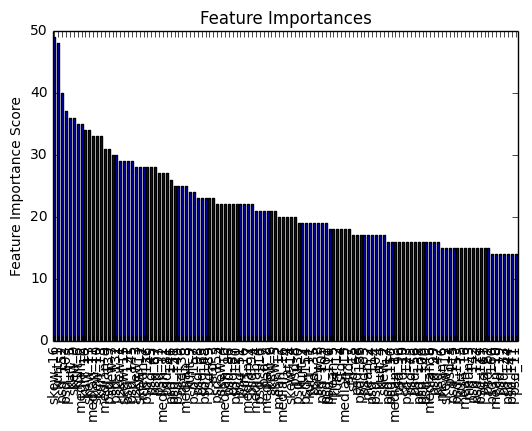

In [5]:
%reset -f
%matplotlib inline

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
dirToInclude=parentdir +'/features/'

import pymc3 as pm
sys.path.insert(0,dirToInclude)

import IeegConsts
from IeegConsts import *
from IeegFeatures import *

import pandas
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import matplotlib.pyplot as plt


np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 100)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 6)
    
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
%matplotlib inline
   
train_dir=TRAIN_DATA_FOLDER_IN_ALL
ieegFeatures= IeegFeatures(train_dir, True)
df_cols_train=ieegFeatures.ieegGenCols()
print len(df_cols_train)
F_NAME_TRAIN= TRAIN_FEAT_BASE + TRAIN_PREFIX_ALL +'-feat_TRAIN_df.csv'
X_df_train=pandas.read_csv(F_NAME_TRAIN, engine='python') 
X_df_train.drop('Unnamed: 0', axis=1, inplace=True)
X_df_train.head(3)


def plot_traces(traces, retain=1000):    
    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')
        

        
import xgboost as xgb
algo_xgbm = xgb.XGBClassifier(base_score=0.5, colsample_bytree=0.5, 
                               gamma=0.017,learning_rate=0.15, max_delta_step=0, 
                               max_depth=12, min_child_weight=3, n_estimators=2000, 
                               nthread=-1, objective='binary:logistic', seed=0, 
                               silent=1, subsample=0.9)
algo_=algo_xgbm

X_df_train_SINGLE=X_df_train

answers_1_SINGLE = list (X_df_train_SINGLE[singleResponseVariable].values)
X_df_train_SINGLE = X_df_train_SINGLE.drop(singleResponseVariable, axis=1)
X_df_train_SINGLE.drop('id', axis=1, inplace=True)
X_df_train_SINGLE.drop('file', axis=1, inplace=True)
X_df_train_SINGLE.drop('patient_id', axis=1, inplace=True)
X_df_train_SINGLE.drop('file_size', axis=1, inplace=True)
X_df_train_SINGLE.drop('sequence_id', axis=1, inplace=True)
X_df_train_SINGLE.drop('segment', axis=1, inplace=True)
X_df_train_SINGLE=X_df_train_SINGLE.apply(lambda x: pandas.to_numeric(x, errors='ignore'))

# Find the best features using XGboost
trainX, testX, trainY, testY, clf_train1_SINGLE= ieegFeatures.singleAlgoAUC(X_df_train_SINGLE, answers_1_SINGLE, algo_, t_size=0.33)

pred_1= clf_train1_SINGLE.predict(testX)
pred_1.shape

feat_imp = pd.Series(algo_.booster().get_fscore()).sort_values(ascending=False)
feat_imp= feat_imp.head(120)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

# print feat_imp

# Build pasty expression -- feed best features automatically 
glm_factor=list(feat_imp.index)
# glm_factor= list(['var_1', 'mean_9', 'psd_96', 'var_15', 'var_11', 'psd_76', 'psd_37', 'var_6', 'var_13', 'psd_127', 'psd_17', 'psd_50', 'psd_21', 'std_15', 'mean_14', 'psd_95', 'psd_23', 'psd_31', 'psd_52', 'mean_11', 'psd_128', 'psd_92', 'psd_26', 'var_10', 'var_7', 'var_5', 'psd_115', 'psd_32', 'psd_159', 'psd_80', 'psd_54', 'var_2', 'psd_13', 'var_8', 'psd_39', 'std_6', 'std_1', 'psd_150', 'psd_43', 'psd_24', 'std_5', 'psd_73', 'psd_77', 'var_3', 'psd_100', 'psd_108', 'psd_133', 'psd_66', 'psd_42', 'psd_22'])
# glm_factor.remove('result')
# print glm_factor
s='result ~ '

for item in glm_factor:
    s += item + ' + '
s=s[:-2]
print s

Applied logodds-transform to p and added transformed p_logodds_ to model.
 [-----------------100%-----------------] 1000 of 1000 complete in 1836.7 sec

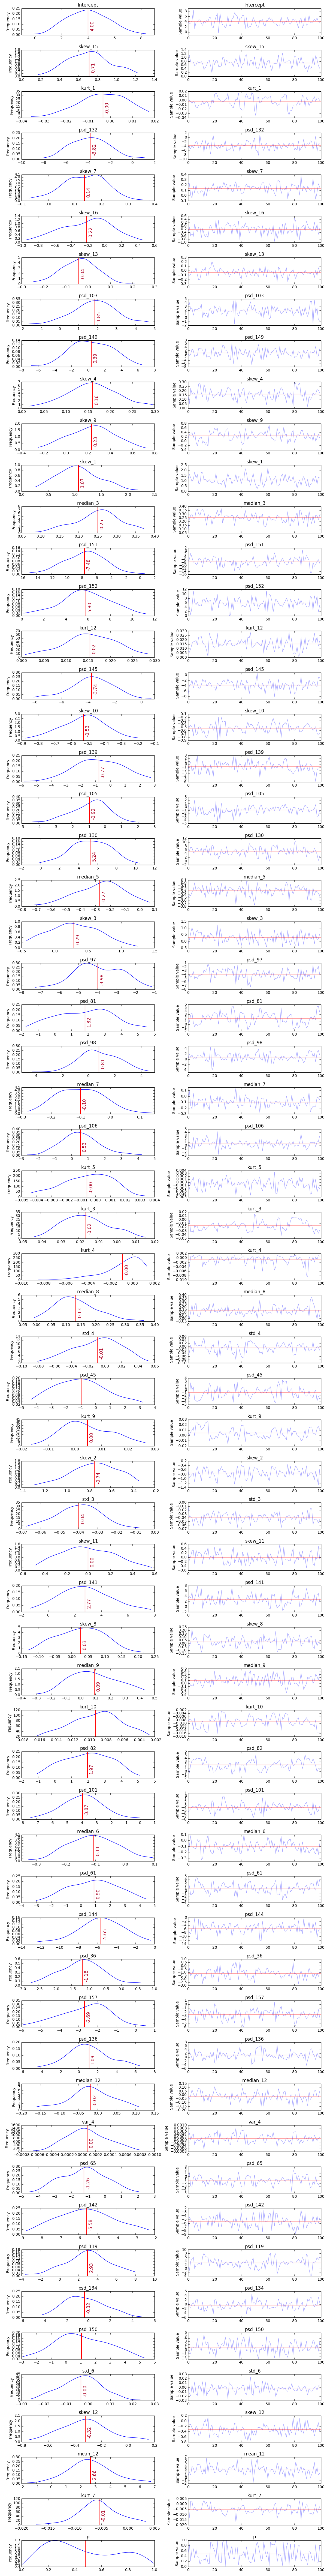

In [3]:
# Pymc expects an R like Df, so the response variable must be included
X_df_train_SINGLE=X_df_train
X_df_train_SINGLE.drop('id', axis=1, inplace=True)
X_df_train_SINGLE.drop('file', axis=1, inplace=True)
X_df_train_SINGLE.drop('patient_id', axis=1, inplace=True)
X_df_train_SINGLE.drop('file_size', axis=1, inplace=True)
X_df_train_SINGLE.drop('sequence_id', axis=1, inplace=True)
X_df_train_SINGLE.drop('segment', axis=1, inplace=True)
X_df_train_SINGLE=X_df_train_SINGLE.apply(lambda x: pandas.to_numeric(x, errors='ignore'))


niter=2000
with pm.Model() as logistic_model:
    pm.glm.glm(s, X_df_train_SINGLE, family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(niter, pm.NUTS(), progressbar=True)
    
# predict
df_trace_logistic_model = pm.trace_to_dataframe(trace_logistic_model[niter//2:])
w_theta = df_trace_logistic_model[glm_factor].mean(0)

df_trace_logistic_model.to_csv("df_trace_logistic_model.csv")
w_theta.to_csv("w_theta.csv")

w_intercept=df_trace_logistic_model['Intercept'].mean(0)


import numpy as np
def predict(new_observation, intercept=w_intercept, theta=w_theta):    
    v = intercept + np.inner(new_observation, w_theta)
    return np.exp(v)/(1+np.exp(v))    

# print w_theta
# print w_intercept 
plot_traces(trace_logistic_model, retain=100)

## Submition

In [4]:
test_dir=TEST_DATA_FOLDER_IN_ALL
ieegFeatures= IeegFeatures(test_dir, False)
df_cols_test=ieegFeatures.ieegGenCols()
print len(df_cols_test)
F_NAME_TEST= TEST_FEAT_BASE + TEST_PREFIX_ALL +'-feat_TEST_df.csv'
X_df_TEST=pandas.read_csv(F_NAME_TEST, engine='python') 
X_df_TEST.drop('Unnamed: 0', axis=1, inplace=True)
# X_df_TEST.drop('id', axis=1, inplace=True)
X_df_TEST.drop('file', axis=1, inplace=True)
X_df_TEST.drop('patient_id', axis=1, inplace=True)
# X_df_TEST.drop('file_size', axis=1, inplace=True)
# X_df_TEST.drop('sequence_id', axis=1, inplace=True)
X_df_TEST.head(3)

#------------------------------------------------------------------------------#
now = datetime.now()
import dis
sub_file = 'submission' + 'mcmc_all_'  + str(len(df_cols_train)) + str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + '.csv'

r= pandas.DataFrame.from_csv('sample_submission.csv')
print('Writing submission: ', sub_file)
f = open(sub_file, 'w') # append mode
f.write('File,Class\n')
total = 0

for index, row in r.iterrows():            
    id_str= index     
    arr = id_str.split("_")
    patient = int(arr[0])        
    new_id= ieegFeatures.getIdFromFileName(id_str) 
#     print str(new_id)
    
    X_df_single_row=X_df_TEST.loc[X_df_TEST['id'] == new_id]
    X_df_single_row.drop('id', axis=1, inplace=True)
    X_df_single_row= X_df_single_row[glm_factor]        
#     X_df_single_row.drop('file', axis=1, inplace=True)
#     X_df_single_row.drop('patient_id', axis=1, inplace=True)                    
    X_df_single_row = np.asarray(X_df_single_row)        
#         print c_pred
    str1 = id_str + ',' + str(predict (tuple (X_df_single_row)[0])) + '\n'  
#     print str1
    
    f.write(str1)
    
f.close()

print('Done writing submission: ', sub_file)

Starting:ieegFeatures:2016-09-22 16:51:05.199385
Cols:499
499
('Writing submission: ', 'submissionmcmc_all_5022016-09-22-16-51.csv')
('Done writing submission: ', 'submissionmcmc_all_5022016-09-22-16-51.csv')
